<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Implied Volatilities and Model Calibration

This setion of the documentation illustrates how to calculate **implied volatilities** and how to calibrate a model to **VSTOXX volatility index call option quotes**. The example implements the calibration for a total of **one month worth of data**.

In [1]:
from dx import *
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn-v0_8')

## VSTOXX Futures & Options Data

We start by loading **VSTOXX data** from a pandas `HDFStore` into `DataFrame` objects (source: Eurex, cf. http://www.eurexchange.com/advanced-services/).

In [2]:
h5 = pd.HDFStore('./data/vstoxx_march_2014.h5', 'r')
vstoxx_index = h5['vstoxx_index'] 
vstoxx_futures = h5['vstoxx_futures'] 
vstoxx_options = h5['vstoxx_options']
h5.close()

**VSTOXX index** for the first quarter of 2014.

<Axes: xlabel='Date'>

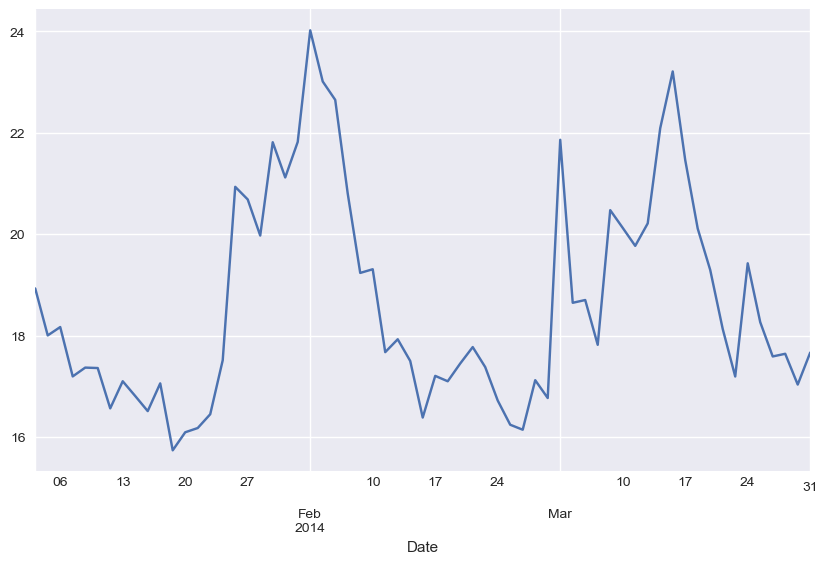

In [3]:
%matplotlib inline
vstoxx_index['V2TX'].plot(figsize=(10, 6))

The **VSTOXX futures** data (8 futures maturities/quotes per day).

In [4]:
vstoxx_futures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, 0 to 503
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       504 non-null    datetime64[ns]
 1   EXP_YEAR   504 non-null    int64         
 2   EXP_MONTH  504 non-null    int64         
 3   PRICE      504 non-null    float64       
 4   MATURITY   504 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 23.6 KB


In [5]:
vstoxx_futures.tail()

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY
499,2014-03-31,2014,7,20.40,2014-07-18
500,2014-03-31,2014,8,20.70,2014-08-15
501,2014-03-31,2014,9,20.95,2014-09-19
502,2014-03-31,2014,10,21.05,2014-10-17
503,2014-03-31,2014,11,21.25,2014-11-21


The **VSTOXX options** data. This data set is quite large due to the large number of European put and call options on the VSTOXX.

In [6]:
vstoxx_options.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46960 entries, 0 to 46959
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       46960 non-null  datetime64[ns]
 1   EXP_YEAR   46960 non-null  int64         
 2   EXP_MONTH  46960 non-null  int64         
 3   TYPE       46960 non-null  object        
 4   STRIKE     46960 non-null  float64       
 5   PRICE      46960 non-null  float64       
 6   MATURITY   46960 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 2.9+ MB


In [7]:
vstoxx_options.tail()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY
46955,2014-03-31,2014,11,P,85.0,63.65,2014-11-21
46956,2014-03-31,2014,11,P,90.0,68.65,2014-11-21
46957,2014-03-31,2014,11,P,95.0,73.65,2014-11-21
46958,2014-03-31,2014,11,P,100.0,78.65,2014-11-21
46959,2014-03-31,2014,11,P,105.0,83.65,2014-11-21


As a helper function we need a function to calculate all relevant **third Fridays** for all relevant maturity months of the data sets.

In [8]:
import datetime as dt
import calendar

def third_friday(date):
    day = 21 - (calendar.weekday(date.year, date.month, 1) + 2) % 7
    return dt.datetime(date.year, date.month, day)

In [9]:
third_fridays = {}
for month in set(vstoxx_futures['EXP_MONTH']):
    third_fridays[month] = third_friday(dt.datetime(2014, month, 1))

In [10]:
third_fridays

{1: datetime.datetime(2014, 1, 17, 0, 0),
 2: datetime.datetime(2014, 2, 21, 0, 0),
 3: datetime.datetime(2014, 3, 21, 0, 0),
 4: datetime.datetime(2014, 4, 18, 0, 0),
 5: datetime.datetime(2014, 5, 16, 0, 0),
 6: datetime.datetime(2014, 6, 20, 0, 0),
 7: datetime.datetime(2014, 7, 18, 0, 0),
 8: datetime.datetime(2014, 8, 15, 0, 0),
 9: datetime.datetime(2014, 9, 19, 0, 0),
 10: datetime.datetime(2014, 10, 17, 0, 0),
 11: datetime.datetime(2014, 11, 21, 0, 0)}

## Implied Volatilities from Market Quotes

Often calibration efforts are undertaken to replicate the **market implied volatilities** or the so-called **volatility surface** as good as possible. With DX Analytics and the `BSM_european_option` class, you can efficiently calculate (i.e. numerically estimate) implied volatilities. For the example, we use the **VSTOXX futures and call options data** from 31. March 2014. 

Some definitions, the pre-selection of option data and the pre-definition of the market environment needed.

In [11]:
V0 = 17.6639  # VSTOXX level on 31.03.2014
futures_data = vstoxx_futures[vstoxx_futures.DATE == '2014/3/31'].copy()
options_data = vstoxx_options[(vstoxx_options.DATE == '2014/3/31')
                              & (vstoxx_options.TYPE == 'C')].copy()
me = market_environment('me', dt.datetime(2014, 3, 31))
me.add_constant('initial_value', 17.6639)  # index on 31.03.2014
me.add_constant('volatility', 2.0)  # for initialization
me.add_curve('discount_curve', constant_short_rate('r', 0.01))  # assumption
options_data['IMP_VOL'] = 0.0  # initialization new iv column

The following loop now **calculates the implied volatilities** for all those options whose strike lies within the defined tolerance level.

In [12]:
%%time
tol = 0.3  # tolerance level for moneyness
for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                options_data.loc[option]['MATURITY']]['PRICE'].values
                # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE']
                             < forward * (1 + tol)):
        # only for options with moneyness within tolerance
        call = options_data.loc[option]
        me.add_constant('strike', call['STRIKE'])
        me.add_constant('maturity', call['MATURITY'])
        call_option = BSM_european_option('call', me)
        options_data.loc[option, 'IMP_VOL'] = \
            call_option.imp_vol(call['PRICE'], 'call', volatility_est=0.6)

CPU times: user 145 ms, sys: 9.87 ms, total: 155 ms
Wall time: 149 ms


A selection of the **results**.

In [13]:
options_data[60:70]

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,IMP_VOL
46230,2014-03-31,2014,5,C,12.0,7.55,2014-05-16,0.000000
46231,2014-03-31,2014,5,C,13.0,6.55,2014-05-16,0.000000
46232,2014-03-31,2014,5,C,14.0,5.55,2014-05-16,1.541568
46233,2014-03-31,2014,5,C,15.0,4.55,2014-05-16,1.321803
46234,2014-03-31,2014,5,C,16.0,3.65,2014-05-16,1.153001
46235,2014-03-31,2014,5,C,17.0,2.90,2014-05-16,1.042549
46236,2014-03-31,2014,5,C,18.0,2.35,2014-05-16,0.997178
46237,2014-03-31,2014,5,C,19.0,1.90,2014-05-16,0.969301
46238,2014-03-31,2014,5,C,20.0,1.55,2014-05-16,0.958777
46239,2014-03-31,2014,5,C,21.0,1.30,2014-05-16,0.968430


And the **complete results visualized**.

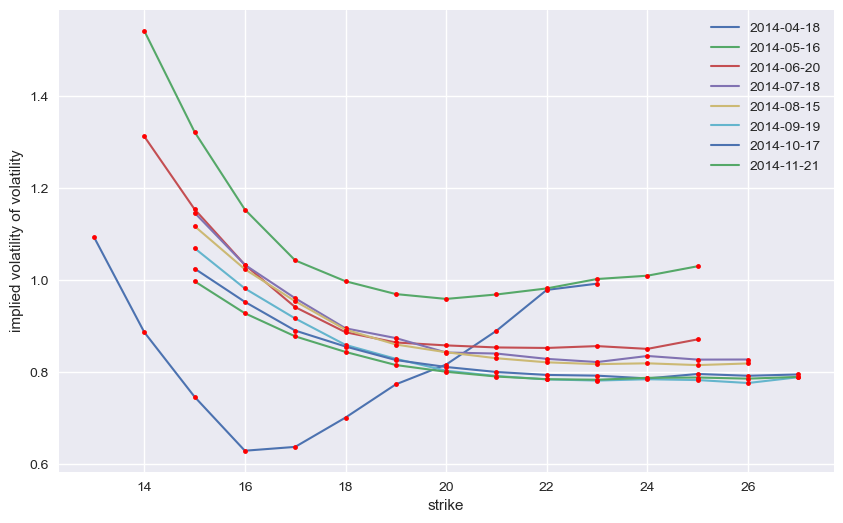

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_data = options_data[options_data.IMP_VOL > 0]
plt.figure(figsize=(10, 6))
for maturity in sorted(set(options_data['MATURITY'])):
    data = plot_data.isin({'MATURITY': [maturity,]})
    data = plot_data[plot_data.MATURITY == maturity]
      # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'],
             label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()

## Market Modeling

This sub-section now implements the model calibration based on **selected options data**. In particular, we choose, for a given pricing date, the following options data:

* for a single maturity only
* call options only
* for a certain moneyness of the options

### Relevant Market Data

The following following returns the **relevant market data per calibration date**:

In [15]:
tol = 0.2
def get_option_selection(pricing_date, maturity, tol=tol):
    ''' Function selects relevant options data. '''
    forward = vstoxx_futures[(vstoxx_futures.DATE == pricing_date)
                & (vstoxx_futures.MATURITY == maturity)]['PRICE'].values[0]
    option_selection = \
        vstoxx_options[(vstoxx_options.DATE == pricing_date)
                     & (vstoxx_options.MATURITY == maturity)
                     & (vstoxx_options.TYPE == 'C')
                     & (vstoxx_options.STRIKE > (1 - tol) * forward)
                     & (vstoxx_options.STRIKE < (1 + tol) * forward)]
    return option_selection, forward

### Options Modeling

Given the options and their respective quotes to which to calibrate the model, the function `get_option_models` returns the **DX Analytics option models for all relevant options**. As **risk factor model** we use the `square_root_diffusion` class. 

In [16]:
def get_option_models(pricing_date, maturity, option_selection):
    ''' Models and returns traded options for given option_selection object. '''
    me_vstoxx = market_environment('me_vstoxx', pricing_date)
    initial_value = vstoxx_index['V2TX'][pricing_date]
    me_vstoxx.add_constant('initial_value', initial_value)
    me_vstoxx.add_constant('final_date', maturity)
    me_vstoxx.add_constant('currency', 'EUR')
    me_vstoxx.add_constant('frequency', 'W')
    me_vstoxx.add_constant('paths', 10000)
    csr = constant_short_rate('csr', 0.01)
      # somewhat arbitrarily chosen here
    me_vstoxx.add_curve('discount_curve', csr)
    
    # parameters to be calibrated later
    me_vstoxx.add_constant('kappa', 1.0)
    me_vstoxx.add_constant('theta', 1.2 * initial_value)
    me_vstoxx.add_constant('volatility', 1.0)
    
    vstoxx_model = square_root_diffusion('vstoxx_model', me_vstoxx)
      # square-root diffusion for volatility modeling
      # mean-reverting, positive process
    
    # option parameters and payoff
    me_vstoxx.add_constant('maturity', maturity)
    payoff_func = 'np.maximum(maturity_value - strike, 0)'
    
    option_models = {}
    for option in option_selection.index:
        strike = option_selection['STRIKE'].loc[option]
        me_vstoxx.add_constant('strike', strike)
        option_models[option] = \
                            valuation_mcs_european_single(
                                    'eur_call_%d' % strike,
                                    vstoxx_model,
                                    me_vstoxx,
                                    payoff_func)
    return vstoxx_model, option_models

The function `calculate_model_values` estimates and returns **model value estimates for all relevant options** given a parameter set for the `square_root_diffusion` risk factor model.

In [17]:
def calculate_model_values(p0):
    ''' Returns all relevant option values.
    
    Parameters
    ===========
    p0 : tuple/list
        tuple of kappa, theta, volatility
    
    Returns
    =======
    model_values : dict
        dictionary with model values
    '''
    kappa, theta, volatility = p0
    vstoxx_model.update(kappa=kappa,
                        theta=theta,
                        volatility=volatility)
    model_values = {}
    for option in option_models:
       model_values[option] = \
         option_models[option].present_value(fixed_seed=True)
    return model_values

## Calibration Functions

### Mean-Squared Error Calculation

The calibration of the pricing model is based on the **minimization of the mean-squared error (MSE)** of the model values vs. the market quotes. The MSE calculation is implemented by the function `mean_squared_error` which also **penalizes** economically implausible parameter values.

In [18]:
i = 0
def mean_squared_error(p0):
    ''' Returns the mean-squared error given
    the model and market values.
    
    Parameters
    ===========
    p0 : tuple/list
        tuple of kappa, theta, volatility
    
    Returns
    =======
    MSE : float
        mean-squared error
    '''
    if p0[0] < 0 or p0[1] < 5. or p0[2] < 0 or p0[2] > 10.:
        return 100
    global i, option_selection, vstoxx_model, option_models, first, last
    pd = dt.datetime.strftime(
            option_selection['DATE'].iloc[0].to_pydatetime(),
            '%d-%b-%Y')
    mat = dt.datetime.strftime(
            option_selection['MATURITY'].iloc[0].to_pydatetime(),
            '%d-%b-%Y')
    model_values = calculate_model_values(p0)
    option_diffs = {}
    for option in model_values:
        option_diffs[option] = (model_values[option]
                              - option_selection['PRICE'].loc[option])
    MSE = np.sum(np.array(list(option_diffs.values())) ** 2) / len(option_diffs)
    if i % 150 == 0:
        # output every 0th and 100th iteration
        if i == 0:
            print('%12s %13s %4s  %6s  %6s  %6s  --> %6s' % \
                 ('pricing_date', 'maturity_date', 'i', 'kappa',
                  'theta', 'vola', 'MSE'))
        print('%12s %13s %4d  %6.3f  %6.3f  %6.3f  --> %6.3f' % \
                (pd, mat, i, p0[0], p0[1], p0[2], MSE))
    i += 1
    return MSE

### Implementing the Calibration Procedure

The function `get_parameter_series` calibrates the model to the market data for **every date** contained in the `pricing_date_list` object for **all maturities** contained in the `maturity_list` object.

In [19]:
import scipy.optimize as spo
def get_parameter_series(pricing_date_list, maturity_list):
    global i, option_selection, vstoxx_model, option_models, first, last
    # collects optimization results for later use (eg. visualization)
    parameters = pd.DataFrame()
    for maturity in maturity_list:
        first = True
        for pricing_date in pricing_date_list:
            option_selection, forward = \
                    get_option_selection(pricing_date, maturity)
            vstoxx_model, option_models = \
                    get_option_models(pricing_date, maturity, option_selection)
            if first is True:
                # use brute force for the first run
                i = 0
                opt = spo.brute(mean_squared_error,
                    ((0.5, 2.51, 1.),   # range for kappa
                     (10., 20.1, 5.),   # range for theta
                     (0.5, 10.51, 5.0)),  # range for volatility
                     finish=None)
            i = 0
            opt = spo.fmin(mean_squared_error, opt,
                 maxiter=200, maxfun=350, xtol=0.0000001, ftol=0.0000001)
            parameters = pd.concat((parameters,
                        pd.DataFrame(
                        {'pricing_date': pricing_date,
                         'maturity': maturity,
                         'initial_value': vstoxx_model.initial_value,
                         'kappa': opt[0],
                         'theta': opt[1],
                         'sigma': opt[2],
                         'MSE': mean_squared_error(opt)}, index=[0]
                        )), ignore_index=True)

            first = False
            last = opt
    return parameters

### The Calibration Itself

This completes the set of necessary function to implement such a **larger calibration effort**. The following code defines the **dates** for which a calibration shall be conducted and for which **maturities** the calibration is required.

In [20]:
%%time
pricing_date_list = pd.date_range('2014/3/1', '2014/3/31', freq='B')
maturity_list = [third_fridays[7]]
parameters = get_parameter_series(pricing_date_list, maturity_list)

pricing_date maturity_date    i   kappa   theta    vola  -->    MSE
 03-Mar-2014   18-Jul-2014    0   0.500  10.000   0.500  -->  4.507
pricing_date maturity_date    i   kappa   theta    vola  -->    MSE
 03-Mar-2014   18-Jul-2014    0   2.500  15.000   5.500  -->  0.022
 03-Mar-2014   18-Jul-2014  150   2.490  17.012   4.665  -->  0.005
Optimization terminated successfully.
         Current function value: 0.004840
         Iterations: 146
         Function evaluations: 296
pricing_date maturity_date    i   kappa   theta    vola  -->    MSE
 04-Mar-2014   18-Jul-2014    0   2.497  17.010   4.674  -->  0.048
 04-Mar-2014   18-Jul-2014  150   2.474  17.633   4.738  -->  0.003
Optimization terminated successfully.
         Current function value: 0.002750
         Iterations: 70
         Function evaluations: 164
pricing_date maturity_date    i   kappa   theta    vola  -->    MSE
 05-Mar-2014   18-Jul-2014    0   2.474  17.633   4.738  -->  0.008
 05-Mar-2014   18-Jul-2014  150   3.042  

## Calibration Results

The results are now stored in the pandas `DataFrame` called `parameters`. We set a new index and inspect the last results. Throughout the MSE is pretty low indicated a good fit of the model to the market quotes.

In [21]:
paramet = parameters.set_index('pricing_date')
paramet.tail()

,maturity,initial_value,kappa,theta,sigma,MSE
pricing_date,,,,,,
2014-03-25,2014-07-18,18.2637,6.250875,18.525022,6.553352,0.002918
2014-03-26,2014-07-18,17.5869,5.189260,18.301087,6.062754,0.002839
2014-03-27,2014-07-18,17.6397,5.787693,18.693053,6.111093,0.002992
2014-03-28,2014-07-18,17.0324,5.683422,18.827773,5.974289,0.002811
2014-03-31,2014-07-18,17.6639,15.246458,18.578233,8.978325,0.003657


This is also illustrated by the visualization of the time series data for the **calibrated/optimal parameter values**. The **MSE** is below 0.01 throughout.

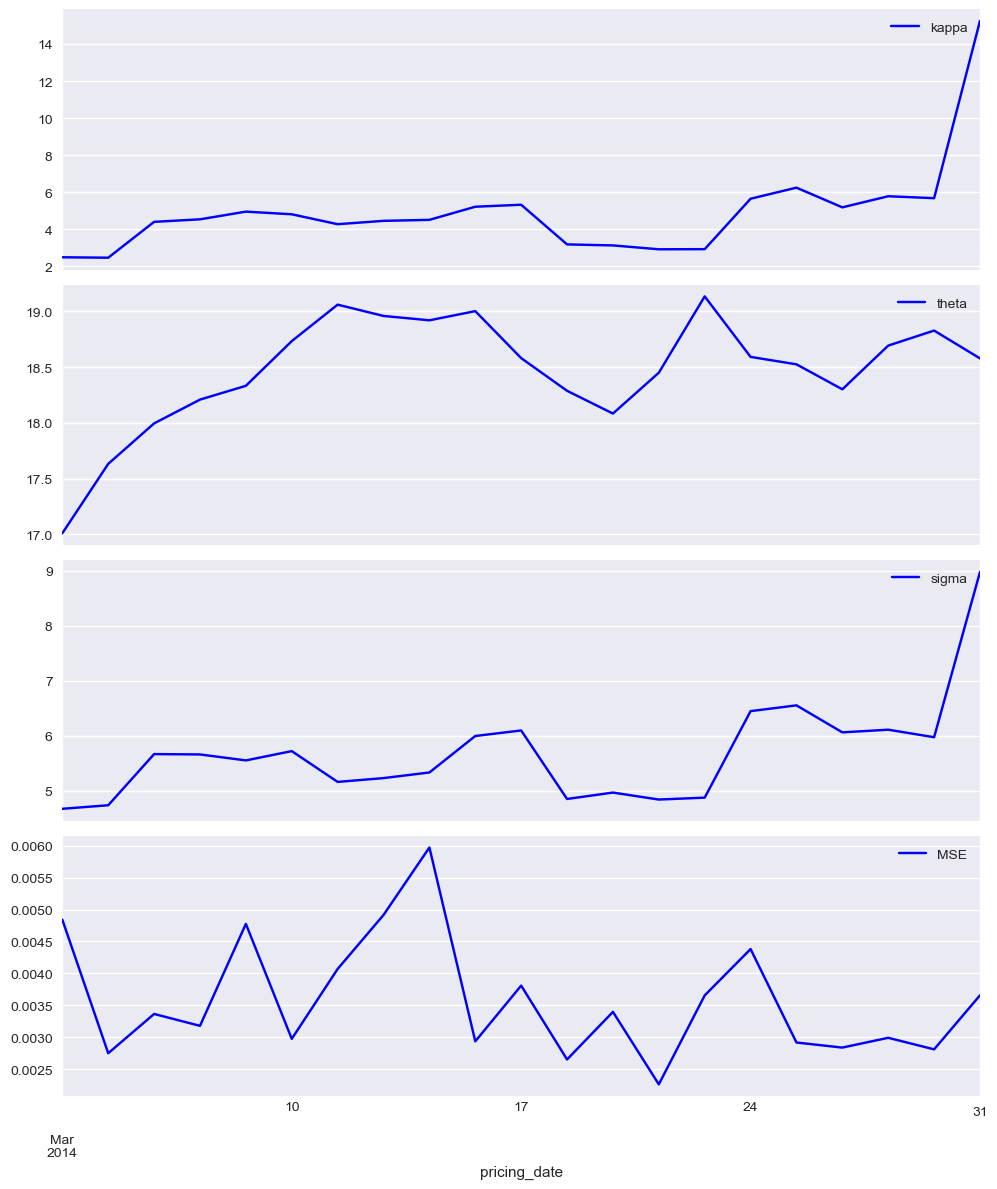

In [22]:
%matplotlib inline
paramet[['kappa', 'theta', 'sigma', 'MSE']].plot(subplots=True, color='b', figsize=(10, 12))
plt.tight_layout()

The following generates a plot of the calibration results for the **last calibration day**. The absolute price differences are below **0.10 EUR** for all options.

Text(0.5, 0, 'strikes')

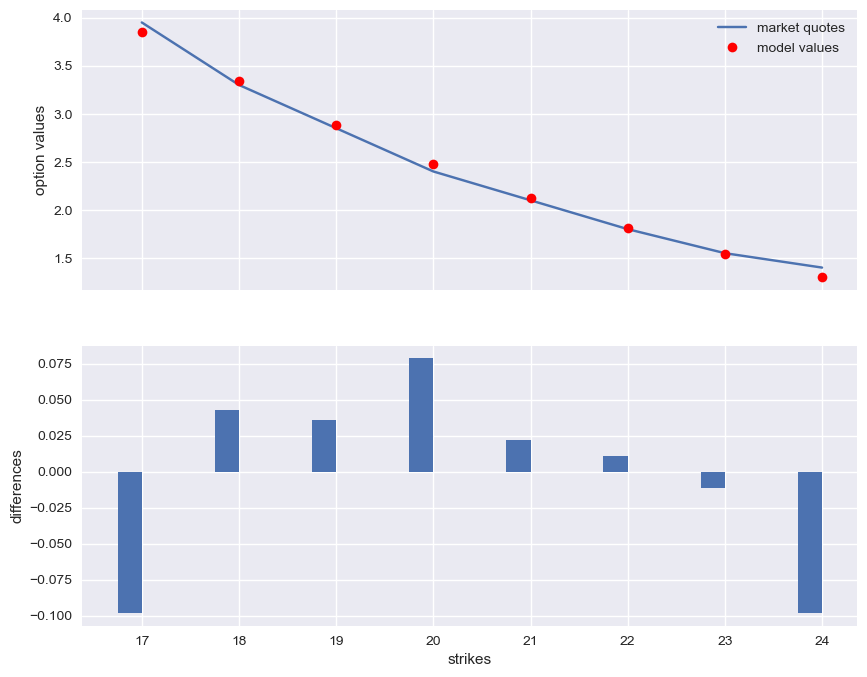

In [23]:
index = paramet.index[-1]
opt = np.array(paramet[['kappa', 'theta', 'sigma']].loc[index])
option_selection = get_option_selection(index, maturity_list[0], tol=tol)[0]
model_values = np.sort(np.array(list(calculate_model_values(opt).values())))[::-1]
import matplotlib.pyplot as plt
%matplotlib inline
fix, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 8))
strikes = option_selection['STRIKE'].values
ax1.plot(strikes, option_selection['PRICE'], label='market quotes')
ax1.plot(strikes, model_values, 'ro', label='model values')
ax1.set_ylabel('option values')
ax1.grid(True)
ax1.legend(loc=0)
wi = 0.25
ax2.bar(strikes - wi / 2., model_values - option_selection['PRICE'],
        label='market quotes', width=wi)
ax2.grid(True)
ax2.set_ylabel('differences')
ax2.set_xlabel('strikes')

**Copyright, License & Disclaimer**

© Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library" or "dx package") is licensed under the GNU Affero General
Public License version 3 or later (see http://www.gnu.org/licenses/).

DX Analytics comes with no representations or warranties, to the extent
permitted by applicable law.

[Learn More & Stay in Touch](https://linktr.ee/dyjh)

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>